# Understanding the temporal trend of erosion in eastern Washington

In [1]:
#### import libraries 
import pandas as pd
import geopandas as gpd
import glob
import os
import itertools
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score

In [2]:
from plotnine import *
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
maindir = 'C:\\Users\\mugalsamrat.dahal\\OneDrive - Washington State University (email.wsu.edu)\\Paper2\\Weppwatershed'
os.chdir(maindir)

In [4]:
###### import functions from my directory ###############
from determine_wateryear import determine_wateryear
#from yearly_erosion_single_hillslope import calcyearlyval
from yearly_watershed import yearly_agg_watershed
from allhillslope_average import allhillslope_average
from yearly_erosion_ebe import calcyearlyerr
from water_balance_aggregate import aggregate_water_balance
from get_daily_value import grab_daily_vals

In [5]:
 my_dir = "F:\\WORK\\Project_2\\WEPPwatershed\\after_anisotropy\\New_batch_past_and_present_slope_length_200m"
#my_dir = "F:\\WORK\\Project_2\\WEPPwatershed\\after_anisotropy\\New_batch_past_and_present_csa_mcl_change"
#my_dir = "F:\\WORK\\Project_2\\WEPPwatershed\\after_anisotropy\\New_batch_past_and_present_csa12p3_mcl_change300m"

In [6]:
dirs = os.listdir(my_dir)

In [7]:
#dirs

In [8]:
# dirs = dirs[2:len(dirs)-3]

In [9]:
def wordfinder(lista, worda):
    
    for a in lista:
        if a == worda:
            val = True
            break
        else:
            val = False
        
    return val

def round_numeric_col(df, num):
    import numpy as np
    tmp = df.select_dtypes(include=[np.number])
    df.loc[:, tmp.columns] = np.round(tmp,2)
    return df

def convert_fact_facet(plot_data,var, fact, facet, facet_name):
    '''
    This function converts a specific factor in a column in such a way that this factor can be plotted in each facets.
    
    var, facet, and fact are all character variable.
    
    var: Name of the colomn that contains the factor that can be compared
    
    fact: The factor that will be compared with all other factor
    
    facet: The name of the coloumn that needs to be faceted
    
    facet_name: This will be the coloumn name of the facet column that will be newly created
    '''

    everyfacet_data = plot_data[plot_data[var]== fact]
    individualfacet_data = plot_data[plot_data[var]!= fact]
    individualfacet_data[facet_name]= individualfacet_data[facet]

    everyfacet_data = pd.merge(everyfacet_data, pd.DataFrame({var:fact, facet_name:individualfacet_data[facet].unique()}))
    plot_data = pd.concat([everyfacet_data, individualfacet_data])

    return plot_data


def NSE(obs, meas):
    '''
    This calculates the NASH SUTCLIFFE EFFICIENCY
    '''
    diff = obs-meas
    mean_obs = obs.mean()
    diff_sq = diff * diff
    diff_sq_sum = diff_sq.sum()
    diff_obs = obs-mean_obs
    diff_obs_sq = diff_obs * diff_obs
    diff_obs_sq_sum = diff_obs_sq.sum()
    ne = 1 - (diff_sq_sum/diff_obs_sq_sum)
    
    return ne

    

mythemes = theme(axis_title_x = element_blank(),
          axis_title_y = element_text(size =20),
          axis_text_x = element_text(size=15),
          axis_text_y = element_text(size=15),
          strip_text_x = element_text(size=15),
         panel_grid_minor = element_blank(), axis_line = element_line(colour = "black"),
         legend_position = (0.8,0.20),
        legend_direction = 'horizontal',
          legend_box_just = 'right',
          legend_title = element_blank(),
           legend_text = element_text(size = 18),
          legend_entry_spacing_x = 20, figure_size = (10,10))

In [10]:
d2 = list()
for d in dirs:
    ind = d.split("_")
    if wordfinder(ind, "past") == True:
        d2.append(d)
        
dirs = d2


### Compiling yearly aggregates for all the runs 



In [11]:
## find yearly aggregate ##
check = 0
a = "WBP"
for i in dirs:

    weppdir = my_dir+"\\"+i

    yearly_wat_df = yearly_agg_watershed(weppdir+"\\wepp\\output")
#     daily_out =  grab_daily_vals(weppdir+"\\wepp\\output\\totalwatsed.txt")
    sed_yearly = yearly_wat_df[0].reset_index()
    wat_yearly = yearly_wat_df[1].reset_index()
    
    wat_yearly['ET'] = wat_yearly['Evaporation (mm)']+ wat_yearly["Transpiration (mm)"]
    
    #tovals_names1_int = sed_yearly_int.columns.tolist()[1:]
    ### sediment detachment ###
    sedcomp = sed_yearly[['WY','Sed. Det. (t/ha)']]
    sedcomp.columns = ['Water Year', 'Erosion (t/ha)']
    
    #############################

    ind = i.split("_")

    if wordfinder(ind, "past") == True:
        period = "Past"
        tillage = "Intense"
        if wordfinder (ind, "altrot") == True:
            rotation = "FW"
        else:
            rotation = "WF"

    else:
        period = "Present"
        
        if wordfinder (ind, "wf") == True:
            rotation = "FW"
        else:
            rotation = "WBP"

        if wordfinder (ind, "intense") == True:
            tillage = "Intense"
        elif wordfinder (ind, "reduced") == True:
            tillage = "Reduced"
        else:
            tillage = "Notill"

    if wordfinder(ind, "springcreek") == True:
        zone = "High"
#         a = "WBP"
    elif wordfinder(ind, "upper") == True:
        zone = "Inter"
#         a = "WBF"
    else:
        zone = "Low"
#         a = "WF"

    ### assign various names ####
    sedcomp["Zone"]=zone
    sedcomp["Tillage"] = tillage
    sedcomp['Rotation'] = rotation
    sedcomp["Time"] = period
    ##############################
    wat_yearly["Zone"] = zone
    wat_yearly["Tillage"] = tillage
    wat_yearly["Rotation"] = rotation
    wat_yearly["Time"] = period
    ##############################
#     daily_out["Zone"] = zone
#     daily_out["Tillage"] = tillage
#     daily_out["Time"] = period
#     daily_out["Rotation"] = rotation
    
    ##########################
    if check < 1:
        emptyss = pd.DataFrame(columns=list(sedcomp.columns))
        emptyss_wat = pd.DataFrame(columns=list(wat_yearly.columns))
        #empty_daily = pd.DataFrame(columns = list(daily_out.columns))
        check = check + 1

    #empty_daily = pd.concat([empty_daily, daily_out])
    emptyss = pd.concat([emptyss,sedcomp])
    emptyss_wat = pd.concat([emptyss_wat, wat_yearly]) 

In [12]:
emptyss['Method'] = "WEPP Watershed version"
emptyss_wat['Method'] = "WEPP Watershed version"
#empty_daily['Method']= "WEPP Watershed version"

In [13]:
# round(emptyss.groupby(['Zone','Time','Rotation','Tillage','Method'])['Erosion (t/ha)'].mean(),2)
#empty_daily.to_csv("Daily_erosion_data_slope_200m_csa4ha.csv",index = False)

### Add observed data and hillslope method data to the dataframe 

In [14]:
############ observed data ##############
#########################################
observed_data = pd.read_csv("F:\WORK\Project_2\save\observed_whit.csv")
observed_data_erosion = observed_data[['Year','Mean Soil Loss']]
observed_data_erosion.columns = ['Water Year', 'Erosion (t/ha)']
observed_data_erosion['Zone'] = "All"
observed_data_erosion['Tillage'] = "Intense"
observed_data_erosion['Rotation'] = "Mixed"
observed_data_erosion['Time'] = "Past"
observed_data_erosion['Method'] = "Observed"
############################################
###########################################

In [15]:
########## Hillslope method #############
########################################
comp_dat=pd.read_csv("F:\\WORK\\Project_2\\WEPP_runs\\WEPPrun\\Two_ofe\\past\\fallow_wheat_rotation\\results\\corr_mat(rot name rename).csv")
comp_dat2 = comp_dat[['Year', 'Fallow-Wheat','Wheat-Fallow']]
comp_dat2.columns = ['Water Year', 'WF','FW']
comp_dat3 = pd.melt(comp_dat2,id_vars = ['Water Year'],
                    value_vars = ['WF','FW'], value_name = "Erosion (t/ha)", var_name = "Rotation")
comp_dat3['Zone'] = "High"
comp_dat3['Tillage'] = "Intense"
comp_dat3['Time'] = "Past"
comp_dat3['Method'] = "WEPP Hillslope version"
# comp_dat3

In [16]:
erosion_temp_all = pd.concat([emptyss,observed_data_erosion,comp_dat3])
# erosion_temp_all.to_csv("WEPPwatershedrun_result_past_present.csv", index = False)

In [17]:
erosion_temp_all = erosion_temp_all[(erosion_temp_all['Water Year']>1938)]
# &(erosion_temp_all['Zone']=="High")

In [18]:
#erosion_temp_all.to_csv("slope200m_csa4ha_erosion_all.csv")

#### Water balance in Whitman County

In [19]:
# emptyss_wat = emptyss_wat.drop(['Storage (mm)','Precip mm)'], axis=1)

In [20]:
wat_avg_temp = round(emptyss_wat.groupby(['Zone','Time','Rotation','Tillage'])['Rain + Melt (mm)','Runoff (mm)',
                                                                   'Transpiration (mm)','Evaporation (mm)','ET',
                                                                  'Percolation (mm)', 'Lateral Flow (mm)'].mean(),2)

In [21]:
wat_avg_temp2 = wat_avg_temp.reset_index()
wat_avg_temp2 = wat_avg_temp2.drop(['Transpiration (mm)','Evaporation (mm)','Percolation (mm)','Lateral Flow (mm)'], axis = 1)

In [22]:
wat_avg_temp2

,Zone,Time,Rotation,Tillage,Rain + Melt (mm),Runoff (mm),ET
0,High,Past,FW,Intense,540.76,123.96,393.56
1,High,Past,WF,Intense,540.73,122.47,392.19
2,Inter,Past,FW,Intense,449.23,83.17,355.60
3,Inter,Past,WF,Intense,449.21,84.57,357.25
4,Low,Past,FW,Intense,347.49,30.90,304.97
5,Low,Past,WF,Intense,347.50,31.68,307.66


#### Annual average erosion in Whitman county

In [23]:
err_avg_temp = erosion_temp_all.groupby(['Zone','Time','Rotation','Tillage','Method'])['Erosion (t/ha)'].mean()
err_avg_temp = round(err_avg_temp,2)
#err_avg_temp.to_csv("slp200m_mclchange12p3.csv")
err_avg_temp

# print(err_avg_temp.reset_index().to_markdown(tablefmt = "grid"))
#err_avg_temp.select_dtypes(include=[np.number])
#round_numeric_col(err_avg_temp, 2)

Zone   Time  Rotation  Tillage  Method                
All    Past  Mixed     Intense  Observed                  53.76
High   Past  FW        Intense  WEPP Hillslope version    48.42
                                WEPP Watershed version    51.85
             WF        Intense  WEPP Hillslope version    45.19
                                WEPP Watershed version    50.66
Inter  Past  FW        Intense  WEPP Watershed version    33.80
             WF        Intense  WEPP Watershed version    34.56
Low    Past  FW        Intense  WEPP Watershed version    13.07
             WF        Intense  WEPP Watershed version    13.75
Name: Erosion (t/ha), dtype: float64

Average annual erosion for the past and the present is presented above. Fallow wheat and Wheat Fallow rotation produced similar erosion in the past. Erosion decreased from past to the present. Use of Fallow Wheat rotation in all three precipitation in the present period yielded less erosion than that of past with the same rotation. This suggest a influence of climate in erosion decrease. The erosion decreased even more with WBP, WBF rotation. 

The erosion is lower as the tillage intensity decreases. For the present Intermediate precipitation zone produce higher erosion with reduced, and no-till and similar erosion with intense tillage. This is because of the Fallow year which yields high erosion as the soil is uncovered.

In [24]:
# check = erosion_temp_all[(erosion_temp_all['Time']=="Present")&(erosion_temp_all['Zone']=="High")&(erosion_temp_all['Tillage']=="Intense")]

In [25]:
# check

In [26]:
d_dict = {'Water Year':int, 'Erosion (t/ha)':float, 'Zone':object, 'Tillage':object, 'Rotation':object, 'Method':object, 'Time':object}
erosion_temp_all=erosion_temp_all.astype(d_dict)

### Erosion in Past; Fallow Wheat and Wheat fallow rotation 

In [27]:
emptyss_past = emptyss[emptyss['Time']=="Past"]
# emptyss_past

In [28]:
emptyss_past.dtypes
d_dict2 = {'Water Year':int, 'Erosion (t/ha)':float, 'Zone':object, 'Tillage':object, 'Rotation':object}
emptyss_past=emptyss_past.astype(d_dict2)
# emptyss_past.dtypes

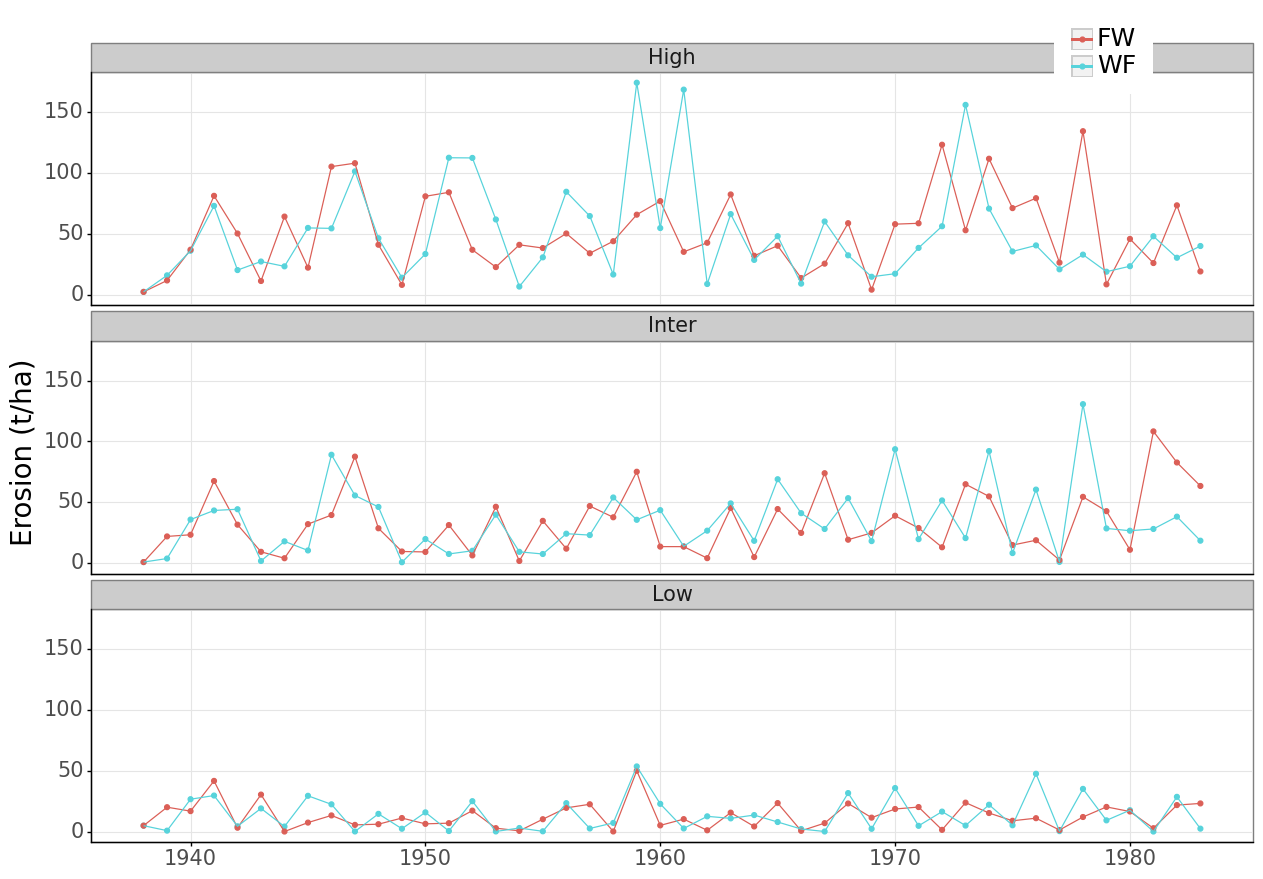

<ggplot: (150368597500)>

In [29]:
ggplot(emptyss_past, aes('Water Year', 'Erosion (t/ha)', color = 'Rotation', group = "Rotation"))+geom_point()+geom_line()+facet_wrap('~Zone',ncol=1)+theme_bw()+mythemes+\
theme(legend_direction = 'vertical', legend_position = (0.8,0.90), figure_size = (15,10))

Altering the rotation in the past altered the erosion peak. Wheat year generally yield high erosion so the peak happened during wheat years in both rotation. 

In [30]:
emptyss_past2 = emptyss_past.groupby(['Water Year','Zone'])['Erosion (t/ha)'].mean().reset_index()

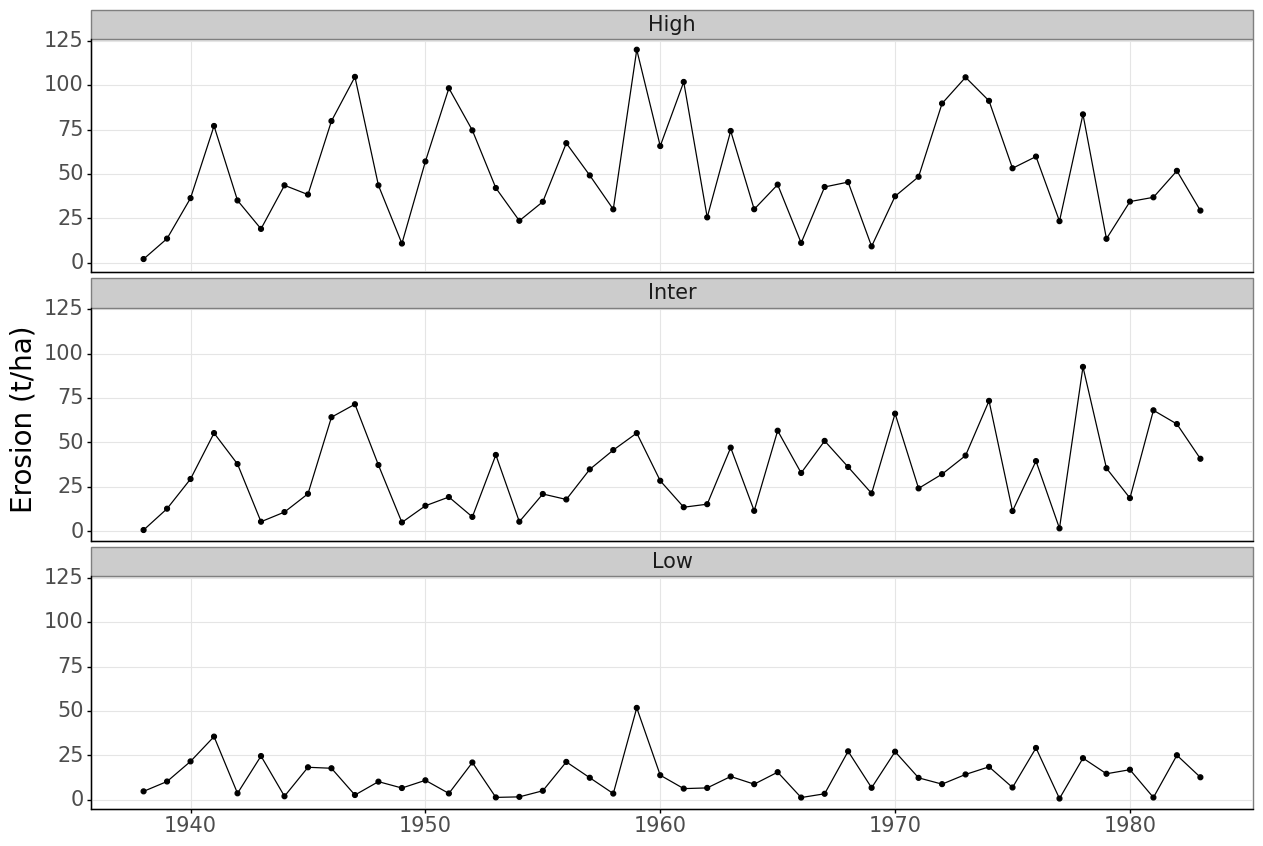

<ggplot: (150366959767)>

In [31]:
ggplot(emptyss_past2, aes('Water Year', 'Erosion (t/ha)'))+geom_point()+geom_line()+facet_wrap('~Zone',ncol=1)+theme_bw()+mythemes+\
theme(legend_direction = 'vertical', legend_position = (0.8,0.90), figure_size = (15,10))

In [33]:
emptyss_past2['Time'] = "Past"

In [35]:
emptyss_past2.to_csv("past_all.csv")

### Comparing observed erosion from kaiser data set with WEPP watershed version

#### Compare with High precipitation zone (separate WF and FW)

In [34]:
plot_data = erosion_temp_all[erosion_temp_all["Time"]=="Past"]
plot_data = plot_data[plot_data["Method"]!="WEPP Hillslope version"]
# plot_data2= plot_data[plot_data["Zone"]== "All"]
plot_data = plot_data[(plot_data["Zone"]== "All")|(plot_data["Zone"]== "High")]
plot_data = convert_fact_facet(plot_data,"Zone","All","Rotation","Facet")
plot_data.groupby(['Zone','Time','Rotation','Tillage','Method'])['Erosion (t/ha)'].mean()
plot_data_A = plot_data


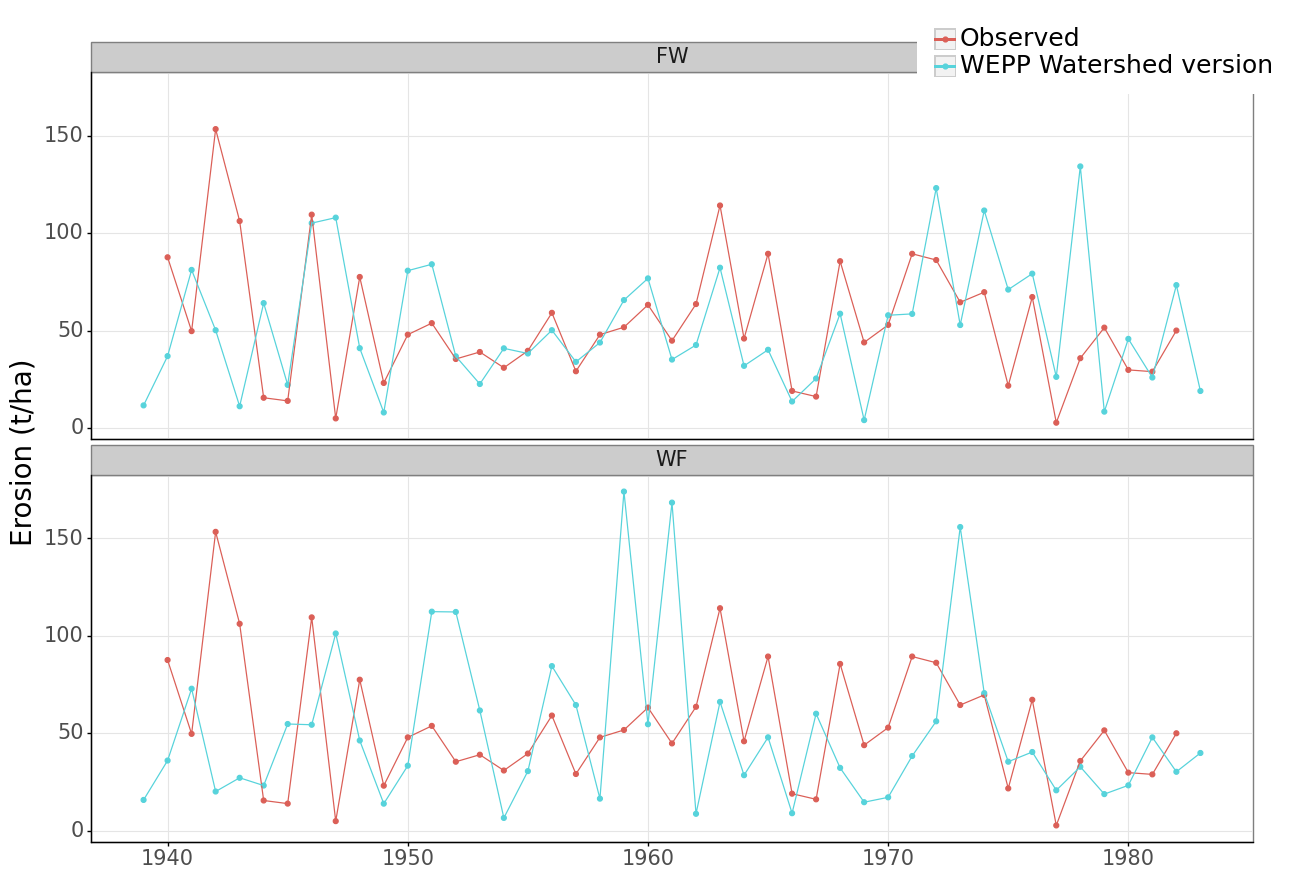

<ggplot: (139052656731)>

In [35]:
ggplot(plot_data, aes('Water Year', 'Erosion (t/ha)',\
                                                               color = 'Method'))+\
geom_point()+geom_line()+facet_wrap('~Facet',ncol=1)+\
theme_bw()+mythemes+\
theme(legend_direction = 'vertical', legend_position = (0.8,0.90), figure_size = (15,10))

Comparing with Observed erosion, FW rotation caught the year-by-year variation better than the WF rotation in high precipitation zone. Year 1959 and 1961 produced two of the peak erosion in WF rotation because those two years had very high precipitation.

#### Compare with High precipitation zone (Combine WF and FW)

In [36]:
plot_data = erosion_temp_all[erosion_temp_all["Time"]=="Past"]
plot_data = plot_data[plot_data["Method"]!="WEPP Hillslope version"]
# plot_data2= plot_data[plot_data["Zone"]== "All"]
plot_data = plot_data[(plot_data["Zone"]== "All")|(plot_data["Zone"]== "High")]
plot_data = convert_fact_facet(plot_data,"Zone","All","Rotation", "Facet")
plot_data_combine = plot_data.groupby(["Water Year","Zone","Method","Time"])["Erosion (t/ha)"].mean().reset_index()
plot_data_combine.groupby(["Zone","Method"])["Erosion (t/ha)"].mean()
#plot_data.groupby(['Zone','Time','Rotation','Tillage','Method'])['Erosion (t/ha)'].mean()

plot_data_B = plot_data_combine
plot_data_B['Rotation'] = "Combined"
plot_data_B['Facet'] = "Combined"
plot_data_C = pd.concat([plot_data_A,plot_data_B])


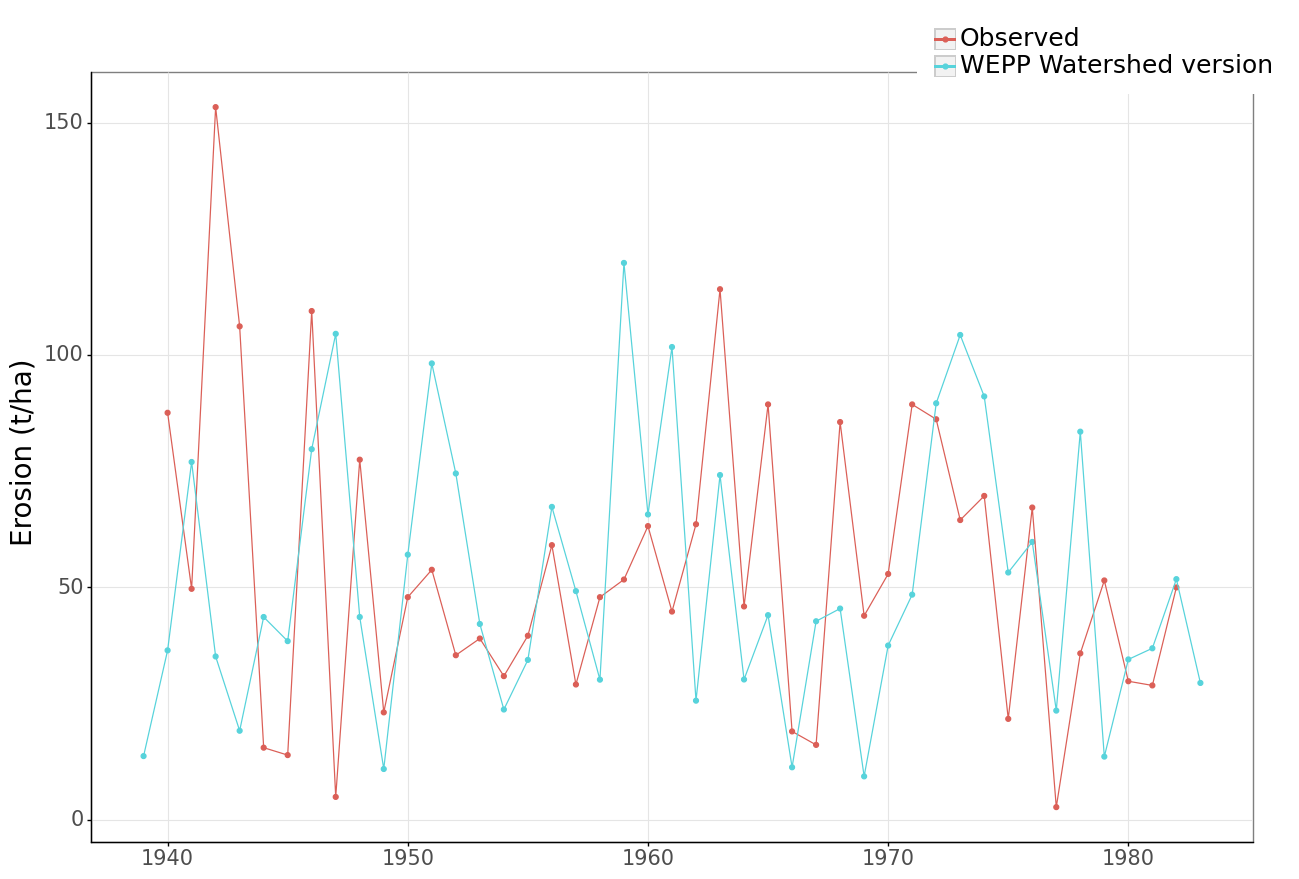

<ggplot: (139052657040)>

In [37]:
ggplot(plot_data_combine, aes('Water Year', 'Erosion (t/ha)',\
                                                               color = 'Method'))+\
geom_point()+geom_line()+\
theme_bw()+mythemes+\
theme(legend_direction = 'vertical', legend_position = (0.8,0.90), figure_size = (15,10))

In [38]:
# plot_data_C["Facet"] = plot_data_C["Facet"].astype("category")
# plot_data_C.Facet = plot_data_C.Categorical(plot_data_C.Facet, 
#                              ordered=True,
#                              categories=["FW", "WF", "Mixed"])

In [39]:
p = ggplot(plot_data_C, aes('Water Year', 'Erosion (t/ha)',\
                                                               color = 'Method'))+\
geom_point()+geom_line()+facet_wrap('~Facet',ncol=1)+\
theme_bw()+mythemes+\
theme(legend_direction = 'vertical', legend_position = (0.75,0.835), figure_size = (15,10))

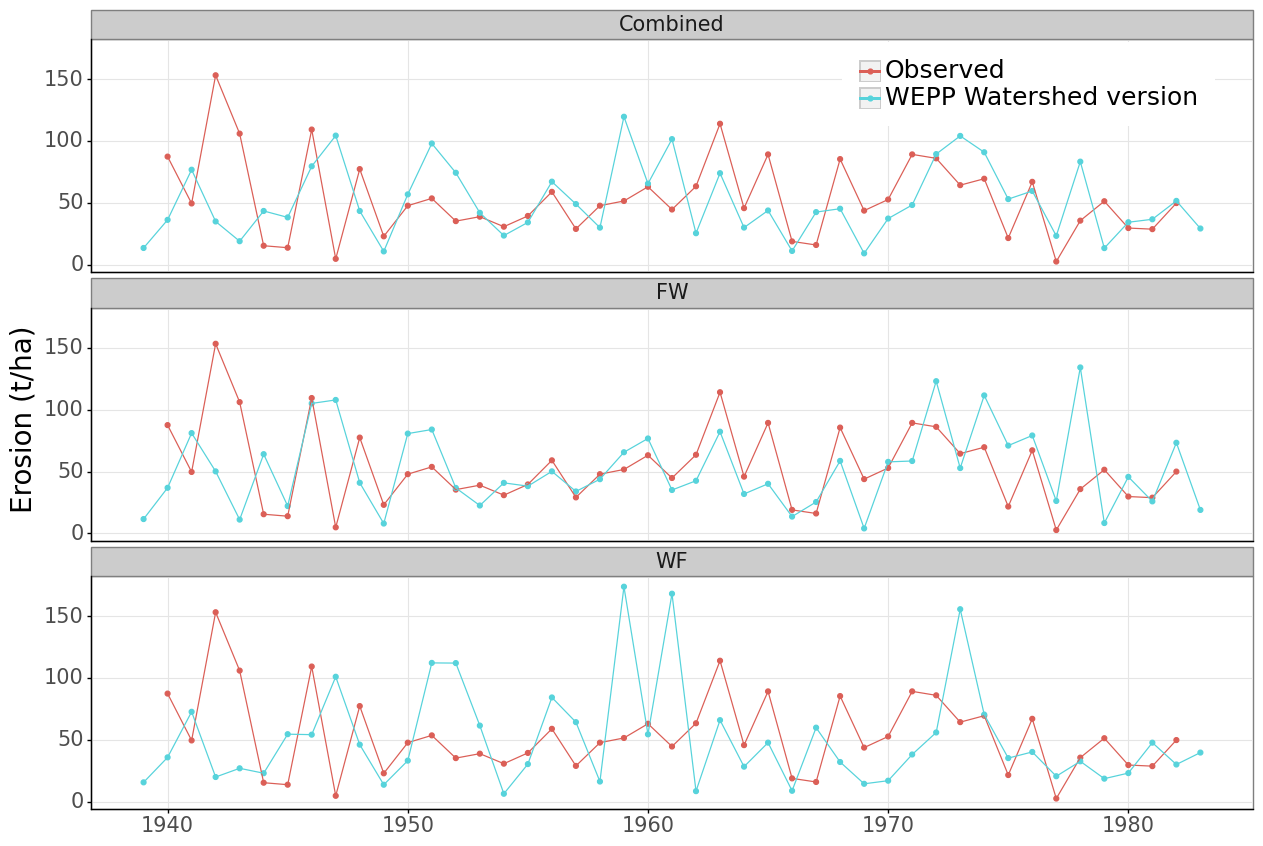

In [40]:
print(p)

In [41]:
# ggsave(plot=p,filename = "comb.eps")

In [42]:
plot_data_C

,Water Year,Erosion (t/ha),Zone,Tillage,Rotation,Time,Method,Facet
0,1940,87.600,All,Intense,Mixed,Past,Observed,WF
1,1940,87.600,All,Intense,Mixed,Past,Observed,FW
2,1941,49.700,All,Intense,Mixed,Past,Observed,WF
3,1941,49.700,All,Intense,Mixed,Past,Observed,FW
4,1942,153.400,All,Intense,Mixed,Past,Observed,WF
...,...,...,...,...,...,...,...,...
83,1981,28.900,All,NaN,Combined,Past,Observed,Combined
84,1981,36.895,High,NaN,Combined,Past,WEPP Watershed version,Combined
85,1982,50.000,All,NaN,Combined,Past,Observed,Combined
86,1982,51.780,High,NaN,Combined,Past,WEPP Watershed version,Combined


In [43]:
plot_data_combine_nse = plot_data_combine[(plot_data_combine['Water Year']>1939)&(plot_data_combine['Water Year']<1983)]

In [44]:
pt_cmb_means = plot_data_combine_nse.groupby(['Method'])['Erosion (t/ha)'].mean()
obs_means = pt_cmb_means['Observed']
# obs_means

In [45]:
### Does replacing the peak erosion values with average value in observed data help??? #####

# plot_data_combine_nse.loc[(plot_data_combine_nse['Water Year']==1942)&(plot_data_combine_nse['Method']=='Observed'),
#                           'Erosion (t/ha)'] = obs_means
# plot_data_combine_nse.loc[(plot_data_combine_nse['Erosion (t/ha)']>100),'Erosion (t/ha)'] = obs_means

In [46]:
# plot_data_combine_nse

In [47]:
plot_data_combine_nse_meas = plot_data_combine_nse[plot_data_combine_nse["Method"]== "WEPP Watershed version"]["Erosion (t/ha)"].reset_index(drop=True)
plot_data_combine_nse_obs = plot_data_combine_nse[plot_data_combine_nse["Method"]== "Observed"]["Erosion (t/ha)"].reset_index(drop=True)
# plot_data_combine_nse_obs

In [48]:
NSE(plot_data_combine_nse_obs,plot_data_combine_nse_meas)

-0.6077047805667364

In [49]:
# NSE(plot_data_combine_nse_obs,plot_data_combine_nse_meas)
# plot_data_combine_nse.corr(method = 'pearson',)
pd.concat([plot_data_combine_nse_obs,plot_data_combine_nse_meas], axis = 1).corr(method = 'pearson')

,Erosion (t/ha),Erosion (t/ha)
Erosion (t/ha),1.000000,0.113117
Erosion (t/ha),0.113117,1.000000


In [50]:
r2_score(plot_data_combine_nse_obs, plot_data_combine_nse_meas)

-0.6077047805667364

Combining wheat fallow and fallow wheat rotation after assuming equal proportion, the modeled erosion followed the trend of observed erosion with general underprediction by modeled erosion (NSE = -0.53). Observed erosion is greater than 100 t/ha for 1942, 1943, 1946, and 1963. Replacing the high erosion rates greater than 100 for these years brought the NSE to -0.745.

#### Compare with all precipitation zones

In [51]:
#### Area of high zone ###### In ha
### Watershed area High_arr = 5256
###### Inter_arr = 3647
####### Low_arr = 8289

###  Whitman precip zone area ###
### extracted from 
## ("F:/WORK/kRESearch/GIS_analysis/Eastern Washington Analysis/grain_area_correction/stat_analyze_all_cnty_data.csv")
###### in (sq. m) ##########
high_area =  1494652500
inter_area =  1130094900
low_area = 202043700
tot_area = high_area + inter_area + low_area
h_ar_wt = high_area/tot_area
i_ar_wt = inter_area/tot_area
l_ar_wt = low_area/tot_area
# area_dict = {"High":  high_area,"Inter":  inter_area,"Low": low_area}
area_dict = {"High":  h_ar_wt,"Inter":  i_ar_wt,"Low": l_ar_wt}
#############################
area_df = pd.DataFrame.from_dict(area_dict, orient = "index")
area_df.index.name = "Zone"
area_df.columns = ["area_wt"]
area_df = area_df.reset_index()
area_df
# area_df.columns = ["md","area_wt"]

,Zone,area_wt
0,High,0.528745
1,Inter,0.399780
2,Low,0.071475


### First need to merge the fallow wheat with the wheat fallow 

In [52]:
### Erosion in the past #######
er_past = erosion_temp_all[erosion_temp_all["Time"]=="Past"]
er_past.groupby(['Zone','Time','Rotation','Tillage','Method'])['Erosion (t/ha)'].mean()

Zone   Time  Rotation  Tillage  Method                
All    Past  Mixed     Intense  Observed                  53.760465
High   Past  FW        Intense  WEPP Hillslope version    48.418769
                                WEPP Watershed version    51.847556
             WF        Intense  WEPP Hillslope version    45.190698
                                WEPP Watershed version    50.661556
Inter  Past  FW        Intense  WEPP Watershed version    33.800444
             WF        Intense  WEPP Watershed version    34.560222
Low    Past  FW        Intense  WEPP Watershed version    13.072000
             WF        Intense  WEPP Watershed version    13.751778
Name: Erosion (t/ha), dtype: float64

In [53]:
#### average after merging fallow wheat with wheat fallow
er_past.groupby(['Zone','Time','Tillage','Method'])['Erosion (t/ha)'].mean()

Zone   Time  Tillage  Method                
All    Past  Intense  Observed                  53.760465
High   Past  Intense  WEPP Hillslope version    46.804733
                      WEPP Watershed version    51.254556
Inter  Past  Intense  WEPP Watershed version    34.180333
Low    Past  Intense  WEPP Watershed version    13.411889
Name: Erosion (t/ha), dtype: float64

In [54]:

#### saving and merging fallow wheat with wheat fallow
er_past_rot_agg = er_past.groupby(['Water Year','Zone','Time','Tillage','Method'])['Erosion (t/ha)'].mean().reset_index()
# er_past_rot_agg

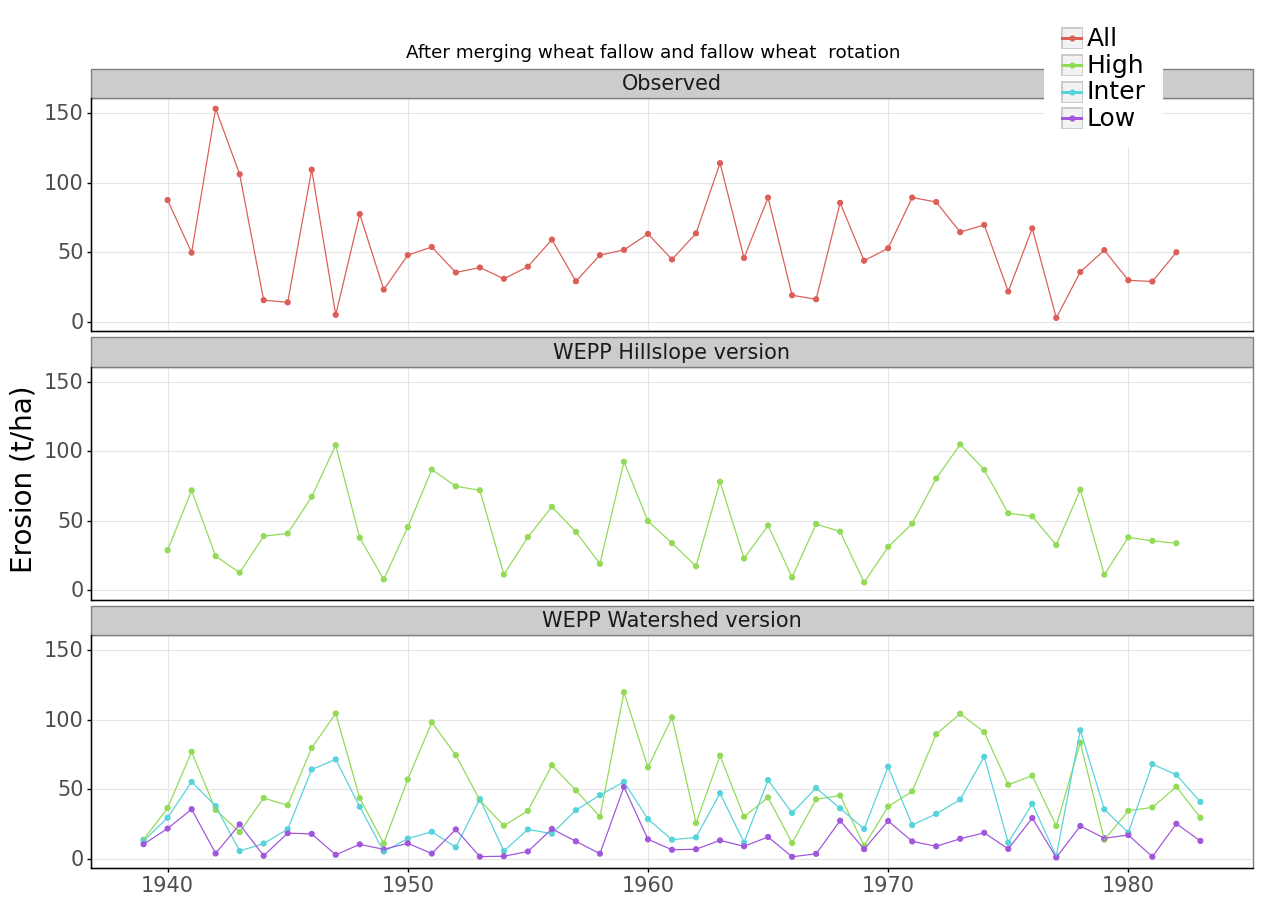

<ggplot: (139052915208)>

In [55]:
ggplot(er_past_rot_agg, aes('Water Year', 'Erosion (t/ha)',color = 'Zone'))+\
geom_point()+geom_line()+facet_wrap('~Method',ncol=1)+ theme_bw()+mythemes+\
theme(legend_direction = 'vertical', legend_position = (0.8,0.90), figure_size = (15,10))+ggtitle("After merging wheat fallow and fallow wheat  rotation")

In [56]:
er_past_rot_agg_wat = er_past_rot_agg[er_past_rot_agg["Method"]== "WEPP Watershed version"]

In [57]:
# er_past_rot_agg =
er_past_rot_agg_wat = pd.merge(er_past_rot_agg_wat, area_df, how="outer")
er_past_rot_agg_wat['weighted er'] = er_past_rot_agg_wat['Erosion (t/ha)']*er_past_rot_agg_wat['area_wt']


In [58]:
er_past_rot_agg_wat_sum = er_past_rot_agg_wat.groupby(['Water Year','Time','Tillage','Method'])['weighted er'].sum().reset_index()
er_past_rot_agg_wat_sum.groupby(['Time','Tillage','Method'])[ 'weighted er'].mean()

Time  Tillage  Method                
Past  Intense  WEPP Watershed version    41.723832
Name: weighted er, dtype: float64

In [59]:
er_past_rot_agg_wat_sum['Zone'] = "All"
er_past_rot_agg_wat_sum['Rotation'] = "Mixed"
er_past_rot_agg_wat_sum = er_past_rot_agg_wat_sum.rename(columns = {'weighted er':'Erosion (t/ha)'})

In [60]:
# er_past_rot_agg_wat_sum

In [61]:
########## add the new combined average to the main dataframe ###########
erosion_temp_all2 = pd.concat([erosion_temp_all,er_past_rot_agg_wat_sum])

In [62]:
plot_data = erosion_temp_all2[(erosion_temp_all2['Zone']=="All")&(erosion_temp_all2['Time']=="Past")]
plot_data.groupby(['Method'])['Erosion (t/ha)'].mean()


Method
Observed                  53.760465
WEPP Watershed version    41.723832
Name: Erosion (t/ha), dtype: float64

In [63]:
plot_data_combine_nse = plot_data[(plot_data['Water Year']>1939)&(plot_data['Water Year']<1983)]

plot_data_combine_nse_meas = plot_data_combine_nse[plot_data_combine_nse["Method"]== "WEPP Watershed version"]["Erosion (t/ha)"].reset_index(drop=True)
plot_data_combine_nse_obs = plot_data_combine_nse[plot_data_combine_nse["Method"]== "Observed"]["Erosion (t/ha)"].reset_index(drop=True)


In [64]:
NSE(plot_data_combine_nse_meas, plot_data_combine_nse_obs)

-2.1884886180026233

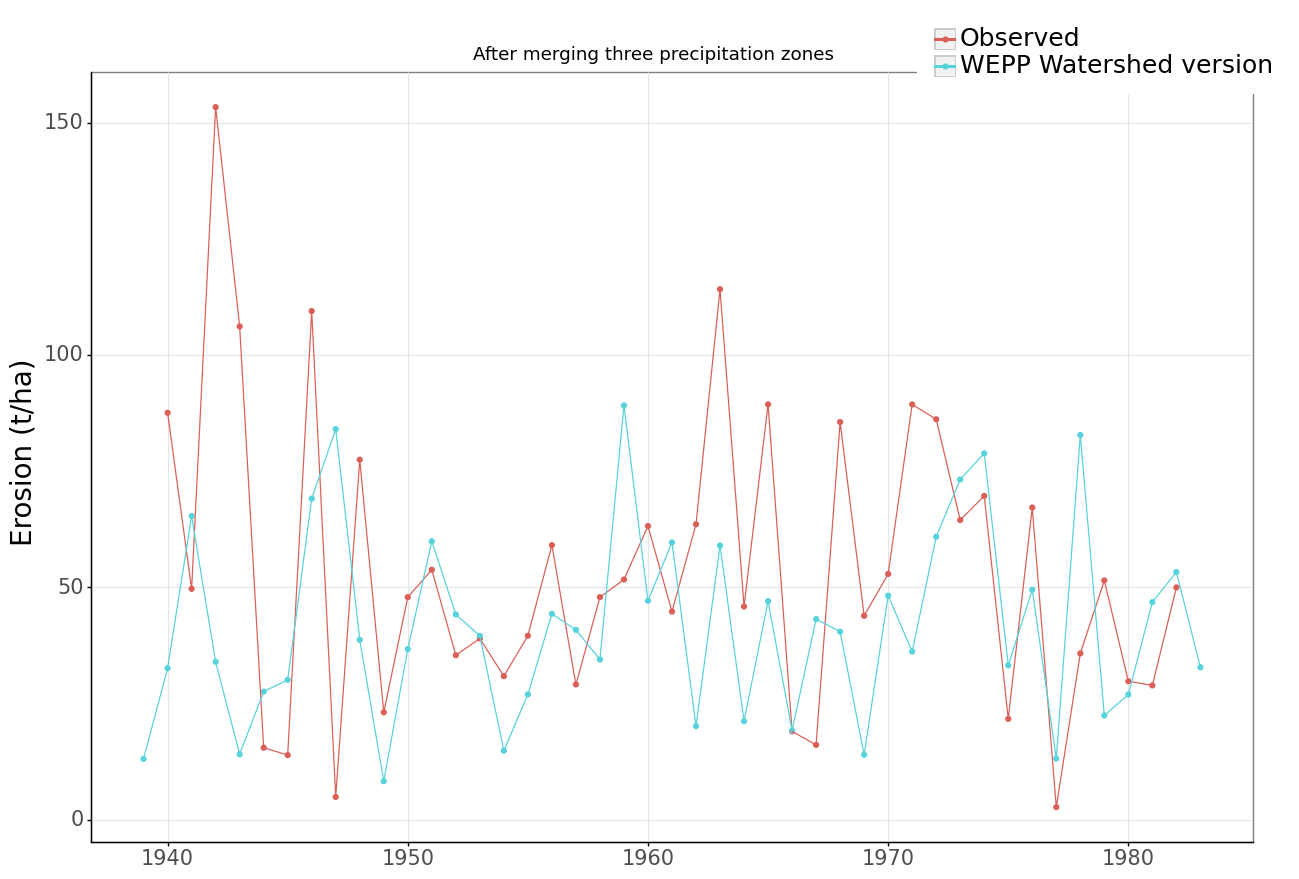

<ggplot: (139052600026)>

In [65]:
ggplot(plot_data, aes('Water Year', 'Erosion (t/ha)',color = 'Method'))+\
geom_point()+geom_line()+ theme_bw()+mythemes+\
theme(legend_direction = 'vertical', legend_position = (0.8,0.90), figure_size = (15,10))+ggtitle("After merging three precipitation zones")

Combining the modeled erosion from all three precipitation zone produced consisently lower erosion (nse < -2). This makes sense because, the observed erosion shouldnt be compared with all three precipitation zone. The field sampling was likely biased towards high precipitation zone. In the kaiser diary, around 67% of the regularly visited farms were in high precipitation zones and 30 % were in intermediate precipitation zones. 

In [66]:
########## Following the same process but only merging with high and intermediate precipitation zones ###############
### using 67% and 33% merge for high and intermediate
er_past_rot_agg_wat = er_past_rot_agg[er_past_rot_agg["Method"]== "WEPP Watershed version"]
area_df.loc[area_df['Zone']=="High","area_wt"] = 0.67
area_df.loc[area_df['Zone']=="Inter","area_wt"] = 0.33
area_df.loc[area_df['Zone']=="Low","area_wt"] = 0
er_past_rot_agg_wat = pd.merge(er_past_rot_agg_wat, area_df, how="outer")
er_past_rot_agg_wat['weighted er'] = er_past_rot_agg_wat['Erosion (t/ha)']*er_past_rot_agg_wat['area_wt']
er_past_rot_agg_wat_sum = er_past_rot_agg_wat.groupby(['Water Year','Time','Tillage','Method'])['weighted er'].sum().reset_index()
er_past_rot_agg_wat_sum.groupby(['Time','Tillage','Method'])[ 'weighted er'].mean()
er_past_rot_agg_wat_sum['Zone'] = "High+Low"
er_past_rot_agg_wat_sum['Rotation'] = "Mixed"
er_past_rot_agg_wat_sum = er_past_rot_agg_wat_sum.rename(columns = {'weighted er':'Erosion (t/ha)'})
erosion_temp_all2 = pd.concat([erosion_temp_all,er_past_rot_agg_wat_sum])
plot_data = erosion_temp_all2[(erosion_temp_all2['Rotation']=="Mixed")&(erosion_temp_all2['Time']=="Past")]
plot_data.groupby(['Method'])['Erosion (t/ha)'].mean()

Method
Observed                  53.760465
WEPP Watershed version    45.620062
Name: Erosion (t/ha), dtype: float64

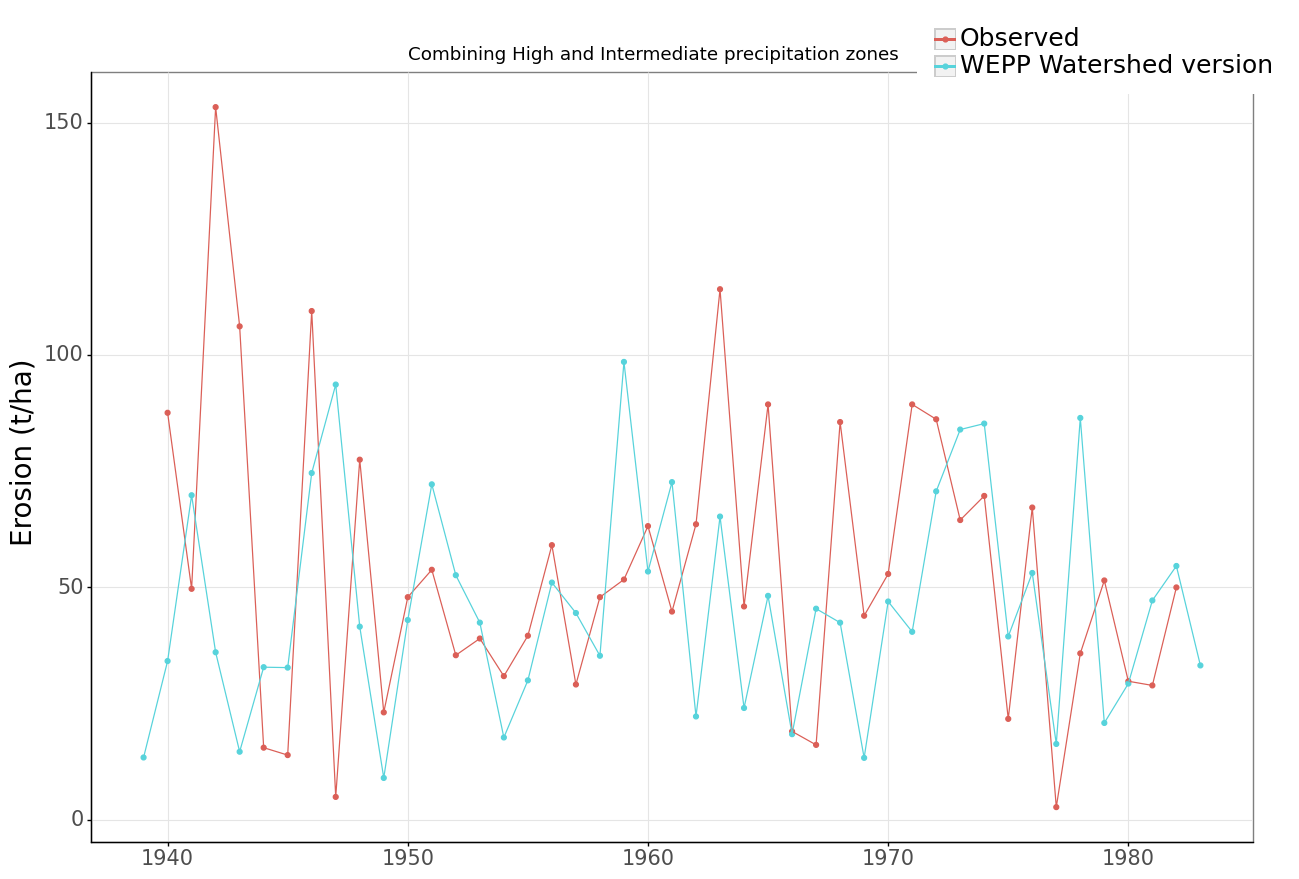

<ggplot: (139052599819)>

In [67]:
ggplot(plot_data, aes('Water Year', 'Erosion (t/ha)',color = 'Method'))+\
geom_point()+geom_line()+ theme_bw()+mythemes+\
theme(legend_direction = 'vertical', legend_position = (0.8,0.90), figure_size = (15,10))+ggtitle("Combining High and Intermediate precipitation zones")

### Merging High and Intermediate zone more nicely

In [68]:
er_past_watshd = er_past[er_past['Method']=="WEPP Watershed version"]

In [69]:
er_past_watshd.groupby(['Time','Zone','Method','Rotation'])[ 'Erosion (t/ha)'].mean()

Time  Zone   Method                  Rotation
Past  High   WEPP Watershed version  FW          51.847556
                                     WF          50.661556
      Inter  WEPP Watershed version  FW          33.800444
                                     WF          34.560222
      Low    WEPP Watershed version  FW          13.072000
                                     WF          13.751778
Name: Erosion (t/ha), dtype: float64

In [70]:
er_past_watshd_rot_comb = er_past_rot_agg[er_past_rot_agg['Method']=="WEPP Watershed version"]
er_past_watshd_rot_comb['Rotation'] = 'Combined'

er_past_watshd = pd.concat([er_past_watshd, er_past_watshd_rot_comb])

In [71]:
er_past_watshd.groupby(['Time','Zone','Method','Rotation'])[ 'Erosion (t/ha)'].mean()

Time  Zone   Method                  Rotation
Past  High   WEPP Watershed version  Combined    51.254556
                                     FW          51.847556
                                     WF          50.661556
      Inter  WEPP Watershed version  Combined    34.180333
                                     FW          33.800444
                                     WF          34.560222
      Low    WEPP Watershed version  Combined    13.411889
                                     FW          13.072000
                                     WF          13.751778
Name: Erosion (t/ha), dtype: float64

In [72]:
er_past_watshd = er_past_watshd[er_past_watshd['Zone']!="Low"]

In [73]:
er_past_watshd.groupby(['Time','Zone','Method','Rotation'])[ 'Erosion (t/ha)'].mean()

Time  Zone   Method                  Rotation
Past  High   WEPP Watershed version  Combined    51.254556
                                     FW          51.847556
                                     WF          50.661556
      Inter  WEPP Watershed version  Combined    34.180333
                                     FW          33.800444
                                     WF          34.560222
Name: Erosion (t/ha), dtype: float64

In [74]:
er_past_watshd_areas = pd.merge(er_past_watshd, area_df, how="left")

In [75]:
er_past_watshd_areas['Weighted_er'] = er_past_watshd_areas['Erosion (t/ha)'] *  er_past_watshd_areas['area_wt']

In [76]:
er_past_watshd_areas_sum = er_past_watshd_areas.groupby(['Water Year','Time','Tillage','Rotation'])['Weighted_er'].sum().reset_index()


In [77]:
er_past_watshd_areas_sum.groupby(['Time','Rotation'])[ 'Weighted_er'].mean()

Time  Rotation
Past  Combined    45.620062
      FW          45.892009
      WF          45.348116
Name: Weighted_er, dtype: float64

In [78]:
er_past_watshd_areas_sum['Zone'] = "Merge High and Intemediate"
er_past_watshd_areas_sum['Method'] = "Merge High and Intemediate"
er_past_watshd_areas_sum = er_past_watshd_areas_sum.rename(columns = {'Weighted_er':"Erosion (t/ha)"})
er_past_watshd_areas_sum['Facet']=er_past_watshd_areas_sum['Rotation']

In [79]:
er_past_watshd.head()

,Water Year,Erosion (t/ha),Zone,Tillage,Rotation,Time,Method
1,1939,15.79,High,Intense,WF,Past,WEPP Watershed version
2,1940,36.01,High,Intense,WF,Past,WEPP Watershed version
3,1941,72.88,High,Intense,WF,Past,WEPP Watershed version
4,1942,20.11,High,Intense,WF,Past,WEPP Watershed version
5,1943,27.15,High,Intense,WF,Past,WEPP Watershed version


In [80]:
er_past_watshd_areas_sum.head()

,Water Year,Time,Tillage,Rotation,Erosion (t/ha),Zone,Method,Facet
0,1939,Past,Intense,Combined,13.38965,Merge High and Intemediate,Merge High and Intemediate,Combined
1,1939,Past,Intense,FW,14.97900,Merge High and Intemediate,Merge High and Intemediate,FW
2,1939,Past,Intense,WF,11.80030,Merge High and Intemediate,Merge High and Intemediate,WF
3,1940,Past,Intense,Combined,34.14985,Merge High and Intemediate,Merge High and Intemediate,Combined
4,1940,Past,Intense,FW,32.38210,Merge High and Intemediate,Merge High and Intemediate,FW


In [81]:
plot_data_9 = er_past_watshd
plot_data_9['Facet'] = plot_data_9['Rotation']
plot_data_10 = pd.concat([plot_data_9, er_past_watshd_areas_sum])

In [82]:
lt_ord0 = ["solid","solid","dashed"]
lt_col0 = ["blue","green","black"]

In [83]:

#### Calculate moving average #######

zone = ["High","Merge High and Intemediate","Inter"]
Facet = ["Combined", "FW", "WF"]
ci = 0
for z in zone:
    for f in Facet:
        
        dd = plot_data_10[(plot_data_10['Zone']==z)&(plot_data_10['Facet']==f)]
        dd['Ers_MA5'] = dd['Erosion (t/ha)'].rolling(3).mean()
        if ci == 0:
            dfss = dd
            ci = 1
        else:
            dfss = pd.concat([dfss, dd])
            
            

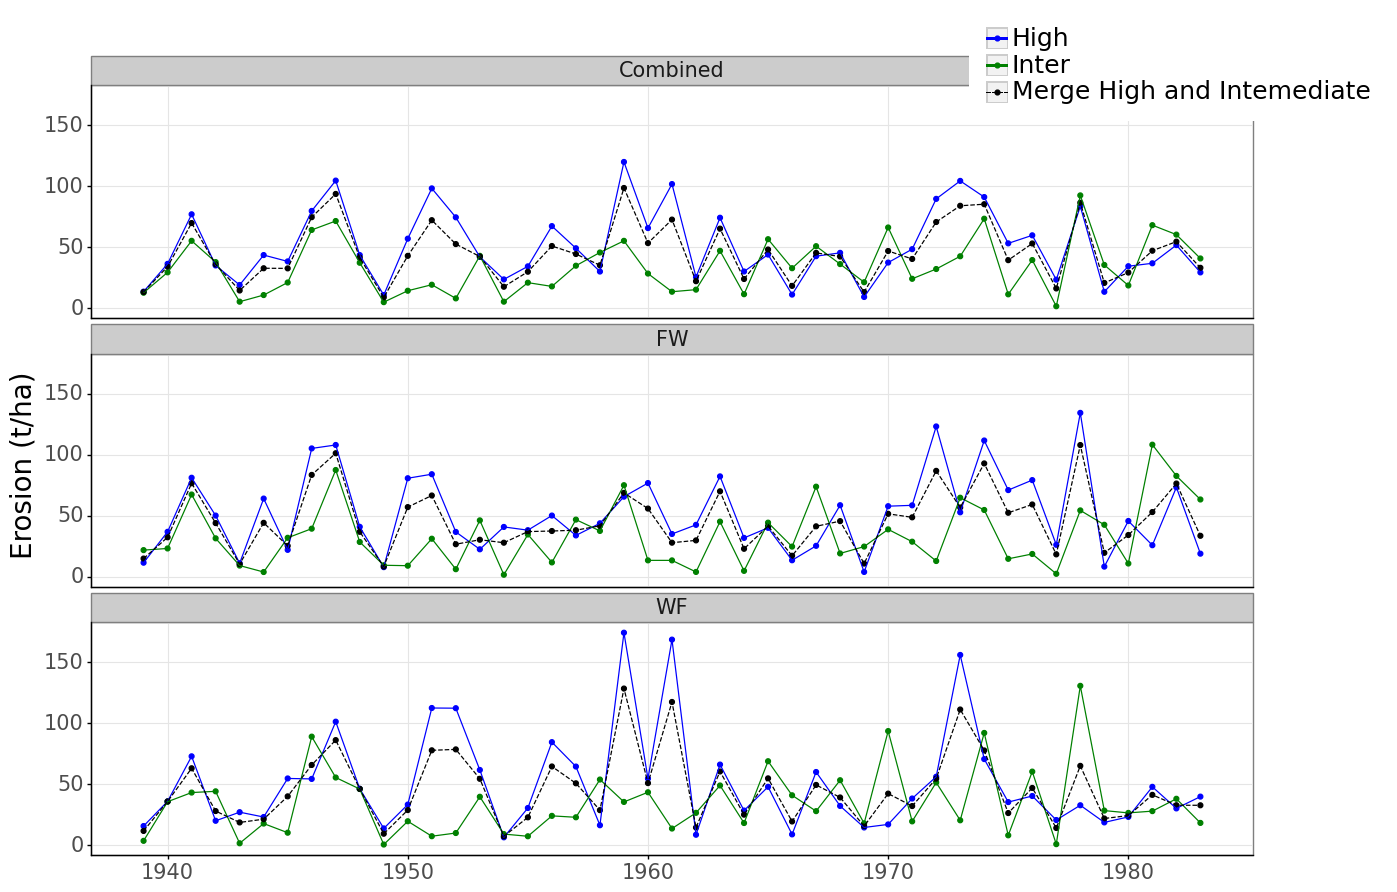

<ggplot: (139054091183)>

In [84]:
ggplot(plot_data_10, aes('Water Year', 'Erosion (t/ha)',\
                                                               color = 'Zone', linetype="Zone"))+\
geom_point()+geom_line()+facet_wrap('~Facet',ncol=1)+\
scale_linetype_manual(values = lt_ord0)+\
scale_color_manual(values = lt_col0)+\
theme_bw()+mythemes+\
theme(legend_direction = 'vertical', legend_position = (0.85,0.9), figure_size = (15,10))

#ggsave(p,"compare_observed.eps")

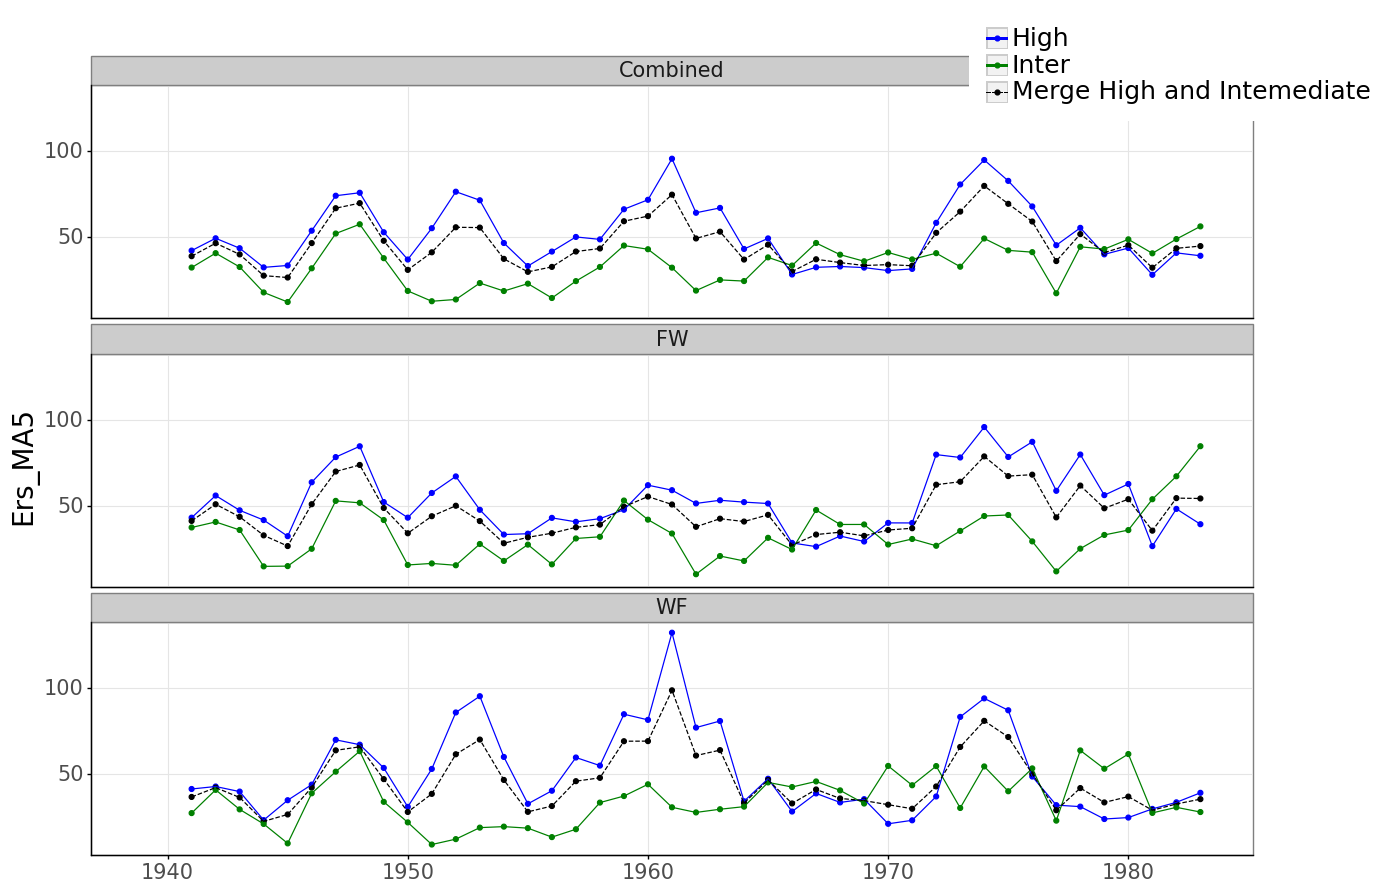

<ggplot: (139052727251)>

In [85]:
ggplot(dfss, aes('Water Year', 'Ers_MA5',\
                                                               color = 'Zone', linetype="Zone"))+\
geom_point()+geom_line()+facet_wrap('~Facet',ncol=1)+\
scale_linetype_manual(values = lt_ord0)+\
scale_color_manual(values = lt_col0)+\
theme_bw()+mythemes+\
theme(legend_direction = 'vertical', legend_position = (0.85,0.9), figure_size = (15,10))

In [86]:
# plot_data = convert_fact_facet(plot_data,"Zone","All","Rotation","Facet")

In [87]:
plot_data_100 = pd.concat([plot_data_C, er_past_watshd_areas_sum])
plot_data_100= plot_data_100[plot_data_100['Water Year']>1939]

In [88]:
plot_data_100.loc[plot_data_100['Method']=="WEPP Watershed version",'Method'] = "High"

In [89]:
lt_ord = ["solid","dashed","solid"]
lt_col = ["blue","black","green"]

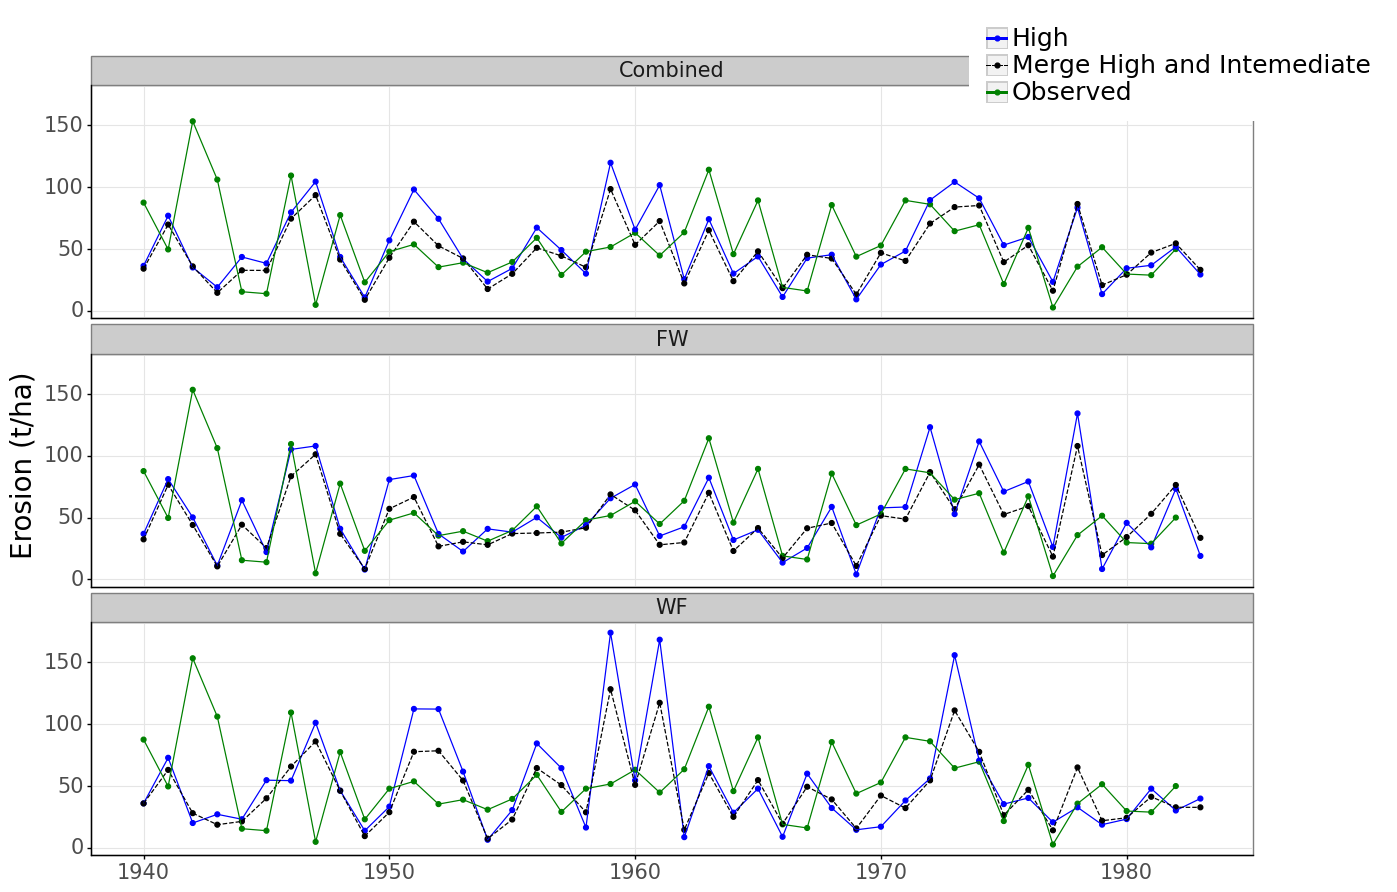

<ggplot: (139051817660)>

In [90]:
ggplot(plot_data_100, aes('Water Year', 'Erosion (t/ha)',\
                                                               color = 'Method', linetype="Method"))+\
geom_point()+geom_line()+facet_wrap('~Facet',ncol=1)+\
scale_linetype_manual(values = lt_ord)+\
scale_color_manual(values = lt_col)+\
theme_bw()+mythemes+\
theme(legend_direction = 'vertical', legend_position = (0.85,0.9), figure_size = (15,10))

#ggsave(p,"compare_observed.eps")

In [91]:
plot_data_20_20 = plot_data_100[plot_data_100['Method']!="High"]

In [92]:
lt_ord2 = ["dashed","solid"]
lt_col2 = ["black","black"]
pt_shp = ["o", "o"]
pt_fl = ["white","black"]

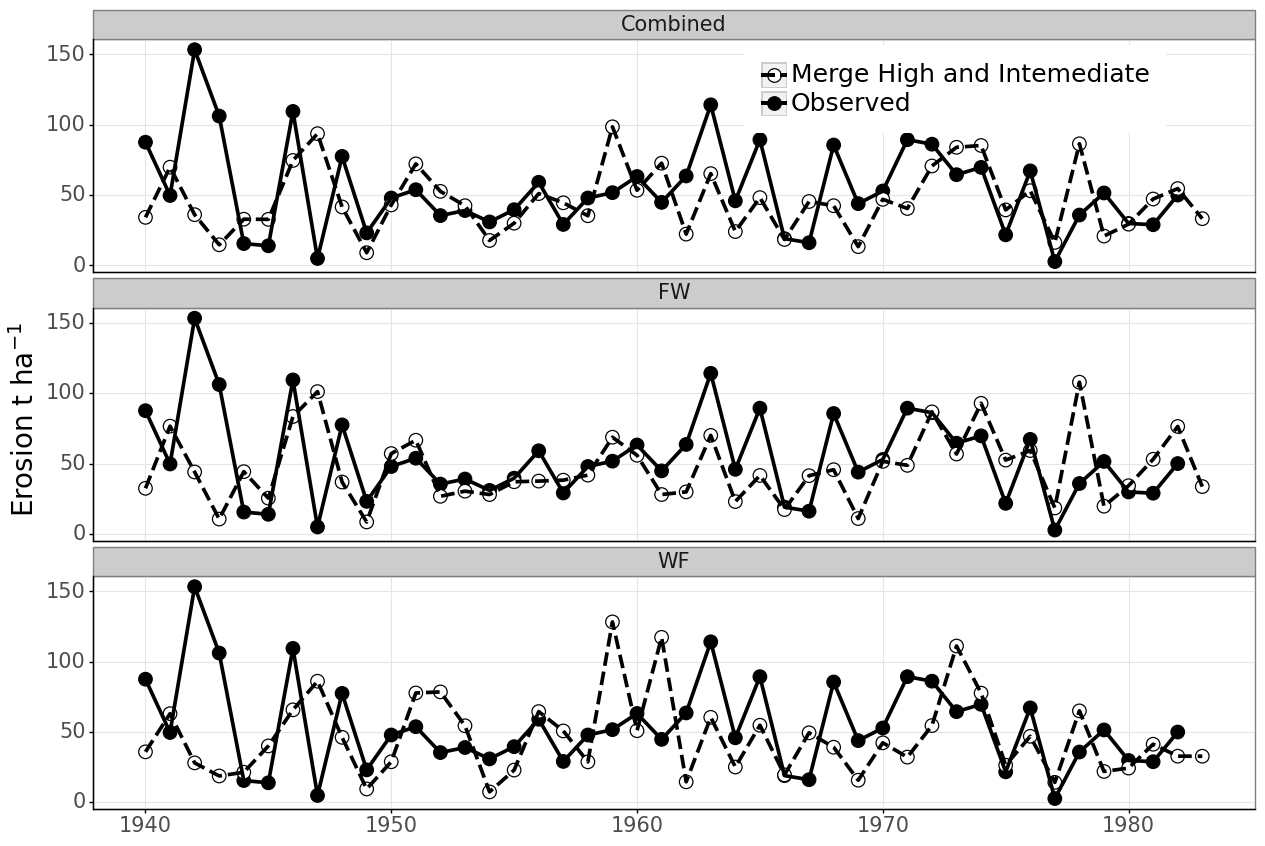

<ggplot: (139053913857)>

In [93]:
p5 = ggplot(plot_data_20_20, aes('Water Year', 'Erosion (t/ha)',\
                                                               color = 'Method', linetype="Method"))+\
geom_point(aes(shape = 'Method', fill = 'Method'), size = 5)+geom_line(size = 1.5)+facet_wrap('~Facet',ncol=1)+\
scale_linetype_manual(values = lt_ord2)+\
scale_color_manual(values = lt_col2)+\
scale_shape_manual(values = pt_shp)+\
scale_fill_manual(values = pt_fl)+\
theme_bw()+mythemes+\
ylab("Erosion t $\mathregular{ha^{-1}}$")+\
theme(legend_direction = 'vertical', legend_position = (0.7,0.83), figure_size = (15,10))
p5
#ggsave(p5, "compare_observed_bw.eps")

In [94]:
#### Now plot only combined and remove WF and FW #########

plot_data_20_20_50  = plot_data_20_20[(plot_data_20_20['Facet']=="Combined")&(plot_data_20_20['Water Year']<1983)]
plot_data_20_20_50['Method'] = plot_data_20_20_50['Method'].astype('category')
plot_data_20_20_50['Method'] = plot_data_20_20_50['Method'].cat.rename_categories({"Merge High and Intemediate": "WEPP simulated"})


In [130]:
import numpy as np

In [95]:
plot_data_20_20_50.to_csv("F:\\WORK\\Project_2\\WEPPwatershed\\after_anisotropy\\erosion_summary\\obs_vs_WEPP.csv")

In [128]:
p555 = ggplot(plot_data_20_20_50, aes('Water Year', 'Erosion (t/ha)',\
                                                               color = 'Method', linetype="Method"))+\
geom_point(aes(shape = 'Method', fill = 'Method'), size = 5)+geom_line(size = 1.5)+\
scale_linetype_manual(values = lt_ord2)+\
scale_color_manual(values = lt_col2)+\
scale_shape_manual(values = pt_shp)+\
scale_y_continuous(limits = [0,200], breaks = range)+\
scale_x_continuous(limits= [1940,1985],breaks = range(1940,1990,5))+\
scale_fill_manual(values = pt_fl)+\
theme_bw()+mythemes+\
ylab("Erosion t $\mathregular{ha^{-1}}$")+\
theme(legend_direction = 'vertical', legend_position = (0.7,0.83), figure_size = (15,10))
p555
ggsave(p555, "compare_observed_bw_only_combined_A.eps")

In [ ]:
scale_x_continuous()

In [135]:
p555 = ggplot(plot_data_20_20_50, aes('Water Year', 'Erosion (t/ha)',\
                                                               color = 'Method', linetype="Method"))+\
geom_point(aes(shape = 'Method', fill = 'Method'), size = 5)+geom_line(size = 1.5)+\
scale_linetype_manual(values = lt_ord2)+\
scale_color_manual(values = lt_col2)+\
scale_shape_manual(values = pt_shp)+\
scale_y_continuous(trans = "log", limits = [2,200], breaks = range(2,240,40))+\
scale_x_continuous(limits= [1940,1985],breaks = range(1940,1990,5))+\
scale_fill_manual(values = pt_fl)+\
theme_bw()+mythemes+\
ylab("Erosion t $\mathregular{ha^{-1}}$")+\
theme(legend_direction = 'vertical', legend_position = (0.7,0.83), figure_size = (15,10))
p555
ggsave(p555, "compare_observed_bw_only_combined_log.eps", width=20, height = 10)

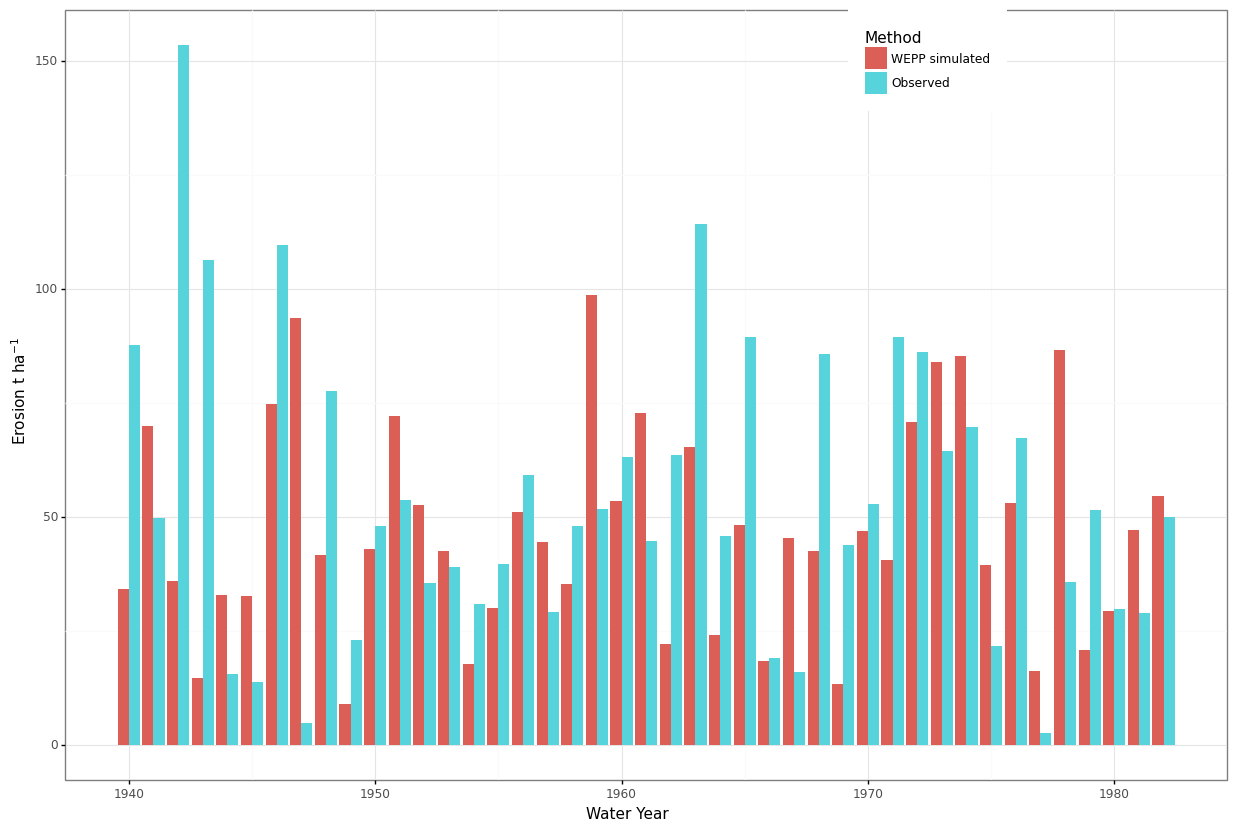

<ggplot: (124810060626)>

In [121]:
p666 = ggplot(plot_data_20_20_50, aes('Water Year', 'Erosion (t/ha)',\
                                                               fill = 'Method'))+\
geom_bar(stat = "identity", position = "dodge")+\
theme_bw()+\
ylab("Erosion t $\mathregular{ha^{-1}}$")+\
theme(legend_direction = 'vertical', legend_position = (0.7,0.83), figure_size = (15,10))
p666
# ggsave(p666, "compare_observed_bw_only_combined.eps")

In [117]:
#### Calculate moving average #######

Method = ["High","Merge High and Intemediate","Observed"]
Facet = ["Combined", "FW", "WF"]
ci = 0
for z in Method:
    for f in Facet:
        
        dd = plot_data_100[(plot_data_100['Method']==z)&(plot_data_100['Facet']==f)]
        dd['Ers_MA5'] = dd['Erosion (t/ha)'].rolling(3).mean()
        if ci == 0:
            dfss2 = dd
            ci = 1
        else:
            dfss2 = pd.concat([dfss2, dd])

In [226]:
#ggplot(dfss2, aes('Water Year', 'Ers_MA5',\
#                                        color = 'Method', linetype="Method"))+\
#geom_point()+geom_line()+facet_wrap('~Facet',ncol=1)+\
#scale_linetype_manual(values = lt_ord2)+\
#scale_color_manual(values = lt_col2)+\
#theme_bw()+mythemes+\
#theme(legend_direction = 'vertical', legend_position = (0.85,0.9), figure_size = (15,10))

#ggsave(p, "compare_observed_3yr.eps")

In [118]:
# dfss3 = dfss2[dfss2['Method']!="High"]
# p4 = ggplot(dfss3, aes('Water Year', 'Ers_MA5',\
#                                                                color = 'Method', linetype="Method"))+\
# geom_point(aes(shape = 'Method', fill = 'Method'))+geom_line()+facet_wrap('~Facet',ncol=1)+\
# scale_linetype_manual(values = lt_ord2)+\
# scale_color_manual(values = lt_col2)+\
# scale_shape_manual(values = pt_shp, size = 5)+\
# scale_fill_manual(values = pt_fl)+\
# theme_bw()+mythemes+\
# theme(legend_direction = 'vertical', legend_position = (0.75,0.87), figure_size = (15,10))

# ggsave(p4, "compare_observed_3yr_bw.eps")

In [150]:
dfss3 = dfss2[dfss2['Method']!="High"]
dfss3['Method2'] = "3-yr_avg. "+dfss3['Method'] 
p4 = ggplot(dfss3, aes('Water Year', 'Ers_MA5',\
                                                               color = 'Method', linetype="Method"))+\
geom_point(aes(shape = 'Method', fill = 'Method'), size = 5)+geom_line(size = 1.5)+facet_wrap('~Facet',ncol=1)+\
scale_linetype_manual(values = lt_ord2)+\
scale_color_manual(values = lt_col2)+\
scale_shape_manual(values = pt_shp)+\
scale_fill_manual(values = pt_fl)+\
ylab("Erosion t $\mathregular{ha^{-1}}$")+\
theme_bw()+mythemes+\
theme(legend_direction = 'vertical', legend_position = (0.75,0.87), figure_size = (15,10))
#p4
ggsave(p4, "compare_observed_3yr_bw.eps")

In [149]:
dfss3

,Water Year,Erosion (t/ha),Zone,Tillage,Rotation,Time,Method,Facet,Ers_MA5,Method2
3,1940,34.14985,Merge High and Intemediate,Intense,Combined,Past,Merge High and Intemediate,Combined,NaN,3-yr moving averageMerge High and Intemediate
6,1941,69.84235,Merge High and Intemediate,Intense,Combined,Past,Merge High and Intemediate,Combined,NaN,3-yr moving averageMerge High and Intemediate
9,1942,36.03920,Merge High and Intemediate,Intense,Combined,Past,Merge High and Intemediate,Combined,46.677133,3-yr moving averageMerge High and Intemediate
12,1943,14.62895,Merge High and Intemediate,Intense,Combined,Past,Merge High and Intemediate,Combined,40.170167,3-yr moving averageMerge High and Intemediate
15,1944,32.82580,Merge High and Intemediate,Intense,Combined,Past,Merge High and Intemediate,Combined,27.831317,3-yr moving averageMerge High and Intemediate
...,...,...,...,...,...,...,...,...,...,...
76,1978,35.80000,All,Intense,Mixed,Past,Observed,WF,35.233333,3-yr moving averageObserved
78,1979,51.50000,All,Intense,Mixed,Past,Observed,WF,30.000000,3-yr moving averageObserved
80,1980,29.80000,All,Intense,Mixed,Past,Observed,WF,39.033333,3-yr moving averageObserved
82,1981,28.90000,All,Intense,Mixed,Past,Observed,WF,36.733333,3-yr moving averageObserved


## Plotting both in the same place

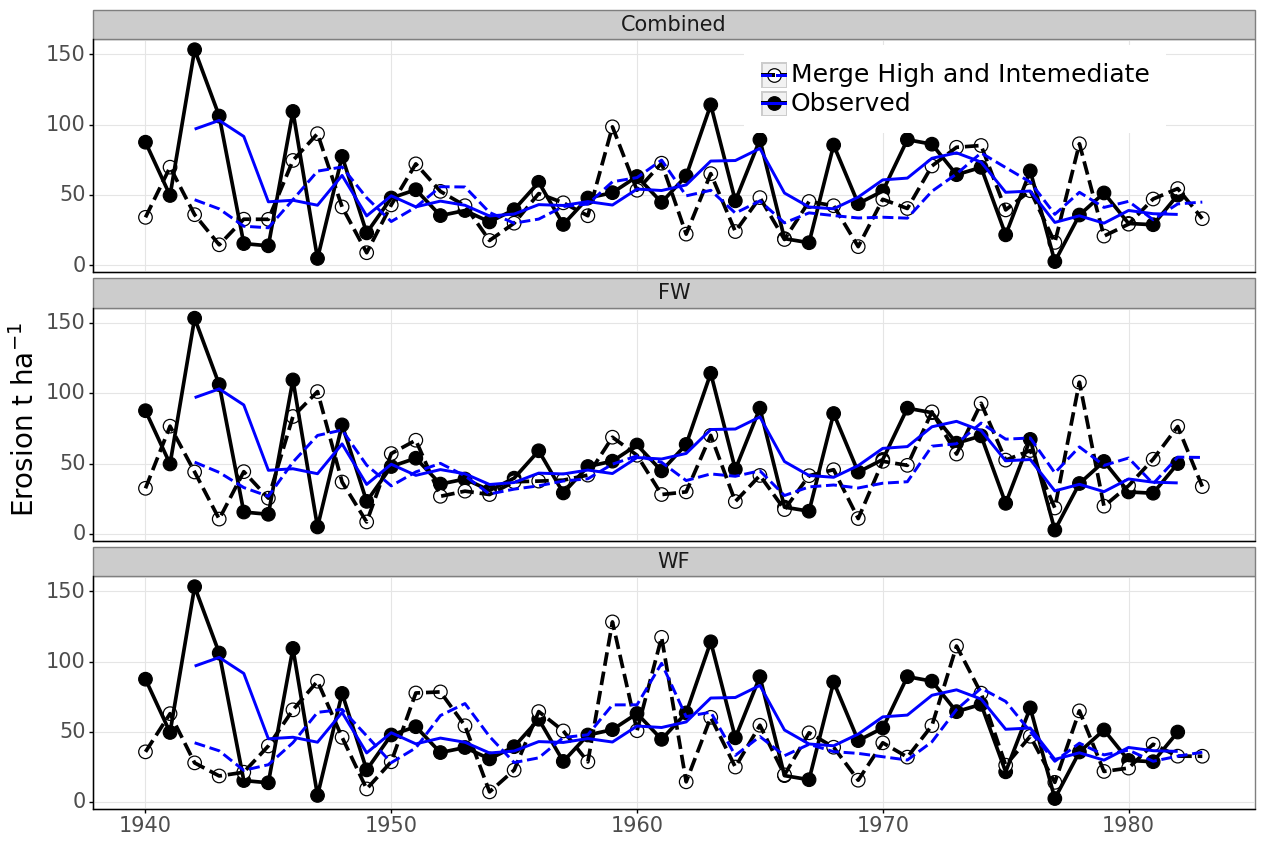

<ggplot: (112805038093)>

In [160]:
p500 = ggplot(plot_data_20_20, aes('Water Year', 'Erosion (t/ha)',\
                                                               color = 'Method', linetype="Method"))+\
geom_point(aes(shape = 'Method', fill = 'Method'), size = 5)+geom_line(size = 1.5)+facet_wrap('~Facet',ncol=1)+\
geom_line(dfss3, aes('Water Year','Ers_MA5'),color="blue", size = 1.2)+\
scale_linetype_manual(values = lt_ord2)+\
scale_color_manual(values = lt_col2)+\
scale_shape_manual(values = pt_shp)+\
scale_fill_manual(values = pt_fl)+\
theme_bw()+mythemes+\
ylab("Erosion t $\mathregular{ha^{-1}}$")+\
theme(legend_direction = 'vertical', legend_position = (0.7,0.83), figure_size = (15,10))

p500
#ggsave(p5, "compare_observed_bw.eps")

### Compare hillslope vs watershed version (high zone)

In [141]:
plot_data = erosion_temp_all2[(erosion_temp_all2["Time"]=="Past")&(erosion_temp_all2["Zone"]=="High")]
plot_data = plot_data[plot_data["Method"]!="Observed"]
plot_data.groupby(['Zone','Tillage','Rotation','Time','Method'])["Erosion (t/ha)"].mean()

Zone  Tillage  Rotation  Time  Method                
High  Intense  FW        Past  WEPP Hillslope version    48.418769
                               WEPP Watershed version    51.847556
               WF        Past  WEPP Hillslope version    45.190698
                               WEPP Watershed version    50.661556
Name: Erosion (t/ha), dtype: float64

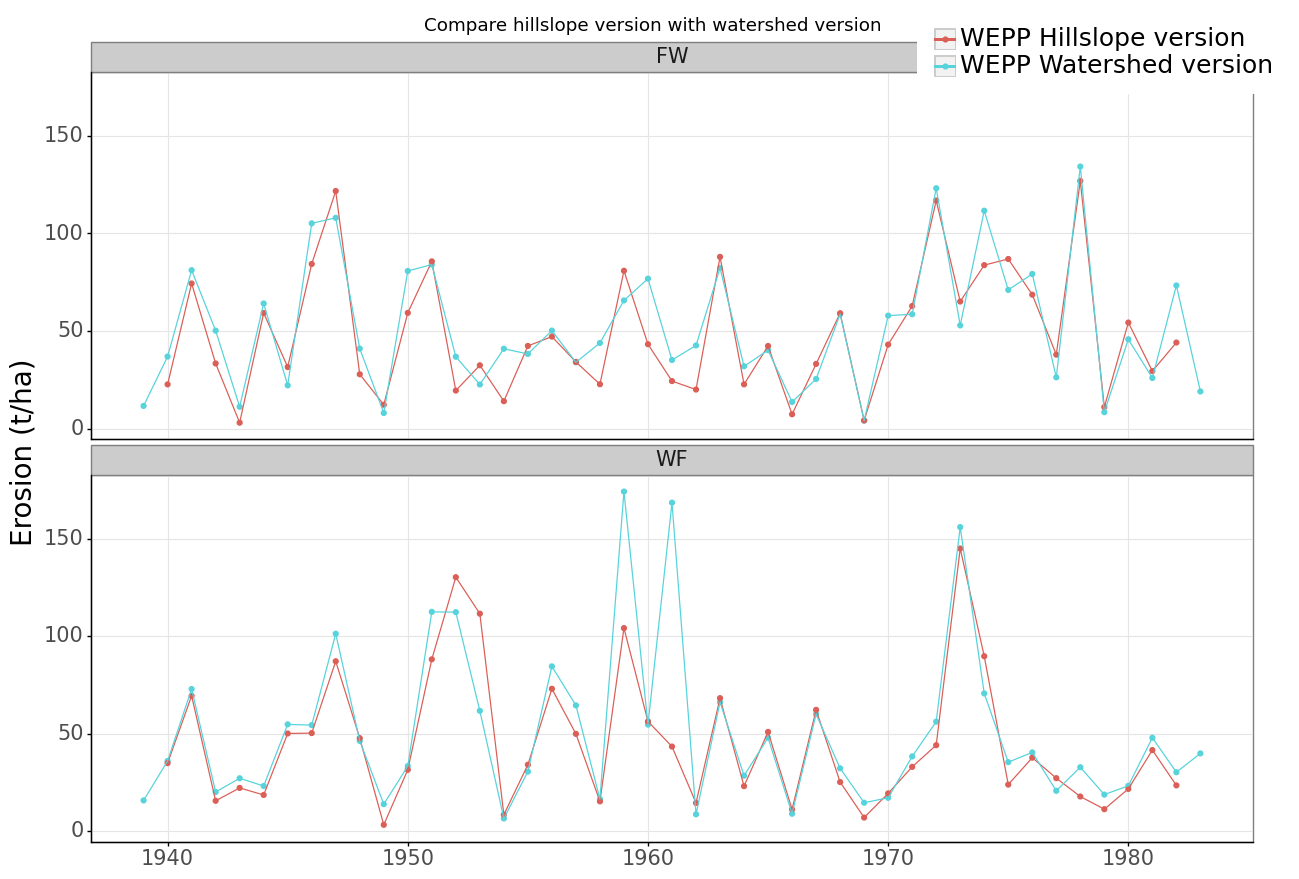

<ggplot: (111015563805)>

In [68]:
ggplot(plot_data, aes('Water Year', 'Erosion (t/ha)',color = 'Method'))+\
geom_point()+geom_line()+facet_wrap('~Rotation', ncol=1)+ theme_bw()+mythemes+\
theme(legend_direction = 'vertical', legend_position = (0.8,0.90), figure_size = (15,10))+ggtitle("Compare hillslope version with watershed version")

Watershed version showed similar result incomparison to Hillslope version. WEPP watershed version showed slightly lower value in this case, because the highest slope steepness selected in high precipitation zone watershed was 35% which was much lower than that was present in the hillslope parameterization.

### Analyzing present erosion ###

In [69]:
check = 1
for m in ['High','Inter','Low']:
    #i = 'High'
    emptyss_pre = emptyss[emptyss['Time'] == "Present"]

    emptyss_pre_z = emptyss_pre[emptyss_pre['Zone'] == m]
    emptyss_pre_z2 = emptyss_pre_z[['Water Year','Erosion (t/ha)','Tillage']]
    emptyss_pre_z2
    emptyss_pre_z2['Tillage'].unique()

    # pd_present.columns = pd_present.columns.droplevel()
    # pd_present = pd_present.reset_index()
    # pd_present

    ### pivot the table to work better with dataframe ####

    pd_present = emptyss_pre_z2.pivot_table(index = 'Water Year', columns='Tillage')
    #pd_present
    pd_present.columns = pd_present.columns.droplevel()
    pd_present = pd_present.reset_index()
    #pd_present

    ##### combine three tillage using percent tillage ################
    till_per = pd.read_csv("F:\\WORK\\Project_2\\WEPPwatershed\\tillage_whitman_yearly.csv")
    #till_per
    till_per = till_per.rename(columns = {'Year':'Water Year'})
    pre_till_per = pd.merge(pd_present,till_per,on ="Water Year")
    pre_till_per

    pre_till_per['Avg']= (pre_till_per["Int"]*pre_till_per["Intense"]/100)+(pre_till_per["Red"]*pre_till_per["Reduced"]/100)+(pre_till_per["No-till"]*pre_till_per["Notill"]/100)
    #pre_till_per
    present_avg = pre_till_per[['Water Year','Avg']]
    #present_avg
    present_avg['Zone']=m
    present_avg['Time'] = 'Present'
    
    if check <2:
        pre_inte_mat = pd.DataFrame(columns = list(present_avg.columns) )
        check = check + 1
    
    pre_inte_mat = pd.concat([pre_inte_mat, present_avg])

In [70]:
#pre_inte_mat

In [71]:
#pre_inte_mat.to_csv("present_all.csv")

In [72]:
# ggplot(pre_inte_mat, aes('Year', 'Avg', color = 'Zone'))+geom_point()+geom_line()+theme_bw()+mythemes+\
# theme(legend_direction = 'vertical', legend_position = (0.8,0.90), figure_size = (15,10))

In [84]:
### Extracting Daily erosion 